## Variables
#### Buses
* bus: ($ch_n, st_n, r_{n,m}, tb_{n,m}, sb_{n,m}$)
    * $ch_n$ - charging state of bus n
    * $st_n$ - state of bus n (3 states: deployed, not-deployed, charging/refueling)
    * $r_{n,m}$ - the route on which the bus is deployed
    * $tb_{n,m}$ - the previous stop the bus travelled to (travel time)
    * $sb_{n,m}$ - the previous stop which was served by the bus (service time)
        * If $tb_n$= $sb_n$, generate travel time for $tb_{n+1}$; $tb_n$ = $tb_{n+1}$ if accepted
        * Else if $tb_n$> $sb_n$, generate service time for $sb_{n+1}$; $sb_n$ = $sb_{n+1}$ if accepted
    * Arrival time - route generated arrays
    * Service Time - route generated arrays

___
### System State New
SS = (n_buses, curr_dem, buses_deployed, buses_recharge, buses_standstill)
SS = (n_buses, curr_dem, buses_deployed, buses_recharge, buses_standstill, route_1_buses, route_2_buses,....)

#### Monitoring System State 

| Time | System State | Bus | Charge | Route | State | Event | Process Time | Demand-Current | Demand-Actual | Demand-Charge |
| ---- | ------------ | --- | ------ | ----- | ----- | ----- | ------------ | -------------- | ------------- | ------------- |
| 0    | (1,1,1,0,0)  | 1   | 50     | '1'   | 1     | 0     | 0            | 0              | 0             | 15            |
| 10.3 | (1,0,1,0,0)  | 1   | 48     | '1'   | 1     | 1     | 10.3         | -              | -             | -             |
| 12.3 | (1,0,1,0,0)  | 1   | 47.5   | '1'   | 1     | 0     | 2.0          | -              | -             | -             |

___

#### Monitoring Bus Deployments

| Time | Demand-Current | Demand-Actual | Demand-Charge | Bus | Charge | Route | Event Array  | Time Array   |
| ---- | -------------- | ------------- | ------------- | --- | ------ | ----- | ------------ | ------------ |
| 0    | 0              | 0             | 15            | 1   | 50     | '1'   | [1, 0, 1]    | [12, 35, 41] |
| 40   | 41             | 40            | 20            | 1   | 35     | '2'   | [1, 0, 1]    | [48, 50, 55] |



In [1]:
import pandas as pd
import numpy as np
import numpy.random as random
from route_functions import *
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm 

In [2]:
path = r"C:\Users\krishrao\Desktop\Laptop Backup\Krishna\Fall'21\IOE 574\Term Project\IOE574_Project\Saved files\\"
varred = pd.read_parquet(path+'bd_table_10_refill_60.parquet')

In [4]:
# intializing route table
routes = pd.read_excel('Model_Parameters.xlsx', 'Routes') # 'Routes-mean.std'

# customizable parameters
running_consumption = 0.075             # fuel(lts.)/kWh per minute
service_consumption = 0.065 
refuel_stations = 2
refuel_consumption = -30
tank_size = 150
conversion_factor = 100/tank_size


# tank level/charge of buses
level_mean = 60       # normal distribution.. can be changed
level_std = 2.5
refuel = 'refill'     # 'recharge'

# setting up initial values for simulation
n_buses = 11                               # number of buses
n_routes = 3                               # number of routes
buses = [bus(level_mean, level_std) for i in range(n_buses)]    # fleet of buses
SimTime = 720

# updating demands
demand_at, demand_r, demand_c = gen_demands(n_routes, SimTime)
demand_ct = demand_at.copy()               # demand current time and demand actual time
dct_flag = 0                               # demand at current time

'''# -----
#### creating fake data & demands
t = 0                                      # start time of simulation
T = 60
buses = [bus(5, 5) for i in range(1)]
demand_at = [0, 40, np.inf]
demand_r = ['1', '2', None]
demand_c = [15, 20, np.inf]
demand_ct = demand_at.copy()         # demand current time and demand actual time
dct_flag = 0                  # demand at current time'''

SS_cols = ['Time', 'System_State', 'Bus', 'Charge', 'Route', 
           'State', 'Event', 'Process_Time', 'Demand_Current', 
           'Demand_Actual', 'Demand_Charge']
BD_cols = ['Time', 'Demand_Current', 'Demand_Actual', 'Demand_Charge', 
           'Bus', 'Charge', 'Route', 'Event_Array', 'Time_Array']
  

In [5]:
replicates = int(varred['Replication'].max())
ss_table = pd.DataFrame(columns=SS_cols+['Replication'])
bd_table = pd.DataFrame(columns=BD_cols+['Replication'])

for i in range(replicates):
    print('-----\nNEW SIMULATION')
    event_array = list(varred['Event_Array'][(varred['Replication']==(i+1))&(varred['Route']!='refill')])
    time_array = list(varred['Time_Array'][(varred['Replication']==(i+1))&(varred['Route']!='refill')])

    # intializing required variabes
    buses = [bus(level_mean, level_std) for i in range(n_buses)]    # fleet of buses
    t = 0                                      # start time of simulation
    T = SimTime

    # updating demands
    demand_at, demand_r, demand_c = gen_demands(n_routes, T)
    demand_ct = demand_at.copy()         # demand current time and demand actual time
    dct_flag = 0                         # demand at current time

    ss_tab, bd_tab = fleet_simulation_varred(t, T, routes, event_array, time_array, buses, refuel, 
                                             running_consumption, service_consumption, refuel_stations, 
                                             refuel_consumption, conversion_factor, demand_at, demand_ct, 
                                             demand_r, demand_c, dct_flag, SS_cols, BD_cols)
    ss_tab['Replication'] = i+1
    bd_tab['Replication'] = i+1
    ss_table = ss_table.append(ss_tab, ignore_index=True)
    bd_table = bd_table.append(bd_tab, ignore_index=True)

-----
NEW SIMULATION
-----
NEW SIMULATION
-----
NEW SIMULATION
-----
NEW SIMULATION
-----
NEW SIMULATION


In [6]:
ss_tab

,Time,System_State,Bus,Charge,Route,State,Event,Process_Time,Demand_Current,Demand_Actual,Demand_Charge,Replication
0,NaN,"[11, 0, 0, 0, 11]",NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,5
1,0.00,"[11, 3, 1, 0, 10]",1,63.138000,1,1,0,0.00,0.0,0.0,25.0,5
2,0.00,"[11, 2, 2, 0, 9]",6,62.098000,2,1,0,0.00,0.0,0.0,25.0,5
3,0.00,"[11, 1, 3, 0, 8]",5,62.031000,3,1,0,0.00,0.0,0.0,25.0,5
4,1.44,"[11, 0, 3, 0, 8]",6,62.026000,2,1,1.0,1.44,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...
4631,772.32,"[11, 0, 2, 0, 9]",8,28.485367,3,1,0.0,2.40,NaN,NaN,NaN,5
4632,772.82,"[11, 0, 2, 0, 9]",1,28.706367,2,1,0.0,0.87,NaN,NaN,NaN,5
4633,774.17,"[11, 0, 2, 0, 9]",8,28.392867,3,1,1.0,1.85,NaN,NaN,NaN,5
4634,774.75,"[11, 0, 1, 0, 10]",1,28.609867,2,1,1.0,1.93,NaN,NaN,NaN,5


In [7]:
bd_tab

,Time,Demand_Current,Demand_Actual,Demand_Charge,Bus,Charge,Route,Event_Array,Time_Array,State,Replication
0,0.00,0.00,0.0,25.0,1,63.138000,1,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[1.94, 2.88, 3.22, 4.29, 6.55, 7.37, 12.66, 14...",1.0,5
1,0.00,0.00,0.0,25.0,6,62.098000,2,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[1.44, 2.32, 8.02, 8.74, 12.08, 12.75, 14.2, 1...",1.0,5
2,0.00,0.00,0.0,25.0,5,62.031000,3,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[4.13, 5.17, 7.85, 8.53, 9.22, 10.09, 11.98, 1...",1.0,5
3,20.00,20.00,20.0,25.0,7,61.600000,3,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[21.94, 22.48, 25.21, 26.14, 27.42, 28.33, 30....",1.0,5
4,30.00,30.00,30.0,25.0,11,61.468000,1,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[33.41, 34.3, 35.33, 35.77, 39.43, 40.26, 44.8...",1.0,5
...,...,...,...,...,...,...,...,...,...,...,...
121,703.12,703.12,690.0,25.0,1,32.036000,2,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[704.67, 705.62, 708.71, 709.21, 711.76, 713.6...",1.0,5
122,703.96,703.96,690.0,25.0,9,31.886000,3,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[707.51, 708.65, 713.15, 714.44, 715.57, 716.5...",1.0,5
123,705.48,705.48,700.0,25.0,3,31.992000,3,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[719.23, 720.04, 723.01, 723.9, 724.36, 725.58...",1.0,5
124,716.63,716.63,705.0,25.0,2,31.008933,1,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[727.07, 727.9, 727.94, 728.56, 732.31, 732.84...",1.0,5


In [8]:
ss_table

,Time,System_State,Bus,Charge,Route,State,Event,Process_Time,Demand_Current,Demand_Actual,Demand_Charge,Replication
0,NaN,"[11, 0, 0, 0, 11]",NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,1
1,0.00,"[11, 3, 1, 0, 10]",4,60.965000,1,1,0,0.00,0.0,0.0,25.0,1
2,0.00,"[11, 2, 2, 0, 9]",10,60.572000,2,1,0,0.00,0.0,0.0,25.0,1
3,0.00,"[11, 1, 3, 0, 8]",8,60.542000,3,1,0,0.00,0.0,0.0,25.0,1
4,0.07,"[11, 0, 3, 0, 8]",4,60.962000,1,1,1.0,0.07,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...
23175,772.32,"[11, 0, 2, 0, 9]",8,28.485367,3,1,0.0,2.40,NaN,NaN,NaN,5
23176,772.82,"[11, 0, 2, 0, 9]",1,28.706367,2,1,0.0,0.87,NaN,NaN,NaN,5
23177,774.17,"[11, 0, 2, 0, 9]",8,28.392867,3,1,1.0,1.85,NaN,NaN,NaN,5
23178,774.75,"[11, 0, 1, 0, 10]",1,28.609867,2,1,1.0,1.93,NaN,NaN,NaN,5


In [9]:
bd_table

,Time,Demand_Current,Demand_Actual,Demand_Charge,Bus,Charge,Route,Event_Array,Time_Array,Replication,State
0,0.00,0.00,0.0,25.0,4,60.965000,1,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[0.07, 1.35, 1.36, 2.54, 5.21, 6.13, 10.77, 12...",1,1.0
1,0.00,0.00,0.0,25.0,10,60.572000,2,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[1.13, 1.62, 3.73, 4.23, 6.6, 7.51, 8.4, 11.37...",1,1.0
2,0.00,0.00,0.0,25.0,8,60.542000,3,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[2.0, 3.2, 7.51, 8.16, 10.88, 11.21, 14.55, 17...",1,1.0
3,20.00,20.00,20.0,25.0,1,60.451000,3,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[22.37, 22.87, 26.39, 26.95, 27.97, 28.87, 29....",1,1.0
4,30.00,30.00,30.0,25.0,2,60.346000,1,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[32.81, 34.48, 36.56, 37.07, 40.4, 41.04, 45.8...",1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
625,703.12,703.12,690.0,25.0,1,32.036000,2,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[704.67, 705.62, 708.71, 709.21, 711.76, 713.6...",5,1.0
626,703.96,703.96,690.0,25.0,9,31.886000,3,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[707.51, 708.65, 713.15, 714.44, 715.57, 716.5...",5,1.0
627,705.48,705.48,700.0,25.0,3,31.992000,3,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[719.23, 720.04, 723.01, 723.9, 724.36, 725.58...",5,1.0
628,716.63,716.63,705.0,25.0,2,31.008933,1,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[727.07, 727.9, 727.94, 728.56, 732.31, 732.84...",5,1.0


In [10]:
varred

,Time,Demand_Current,Demand_Actual,Demand_Charge,Bus,Charge,Route,Event_Array,Time_Array,Replication,State
0,0.00,0.00,0.0,25.0,7,65.619000,1,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[0.07, 1.35, 1.36, 2.54, 5.21, 6.13, 10.77, 12...",1,1.0
1,0.00,0.00,0.0,25.0,10,61.794000,2,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[1.13, 1.62, 3.73, 4.23, 6.6, 7.51, 8.4, 11.37...",1,1.0
2,0.00,0.00,0.0,25.0,9,61.511000,3,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[2.0, 3.2, 7.51, 8.16, 10.88, 11.21, 14.55, 17...",1,1.0
3,20.00,20.00,20.0,25.0,1,61.394000,3,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[22.37, 22.87, 26.39, 26.95, 27.97, 28.87, 29....",1,1.0
4,30.00,30.00,30.0,25.0,5,59.867000,1,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[32.81, 34.48, 36.56, 37.07, 40.4, 41.04, 45.8...",1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
625,703.96,703.96,690.0,25.0,2,29.962000,2,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[704.67, 705.62, 708.71, 709.21, 711.76, 713.6...",5,1.0
626,705.48,705.48,690.0,25.0,10,29.294000,3,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[707.51, 708.65, 713.15, 714.44, 715.57, 716.5...",5,1.0
627,716.63,716.63,700.0,25.0,6,28.766933,3,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[719.23, 720.04, 723.01, 723.9, 724.36, 725.58...",5,1.0
628,725.57,725.57,705.0,25.0,8,28.970400,1,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[727.07, 727.9, 727.94, 728.56, 732.31, 732.84...",5,1.0


___
## Model Analysis

In [11]:
# delay analysis on deployments
num_delay = sum(np.array(bd_table['Demand_Current'] - bd_table['Demand_Actual'])>0)
total_delay = sum(np.nan_to_num(np.array(bd_table['Demand_Current'] - bd_table['Demand_Actual'])))
avg_delay = round(np.mean(np.nan_to_num(np.array(bd_table['Demand_Current'] - bd_table['Demand_Actual']))), 3)
std_delay = round(np.std(np.nan_to_num(np.array(bd_table['Demand_Current'] - bd_table['Demand_Actual']))), 3)

print('Total number of replications (days) -', replicates)
print('Total number of delays -', num_delay)
print('Total delay in minutes -', round(total_delay, 2))
print('Average delay of events in minutes -', round(total_delay, 2)/num_delay)

print('\nAverage delay (all events) in minutes -', round(avg_delay, 2))
print('Std. Deviation of delay (all events) in minutes -', round(std_delay, 2))

print('\nTotal number of route deployments -', sum(bd_table['Route']!='refill'))
print('Total number of refills -', sum(bd_table['Route']=='refill'))
print('\nTotal number of deployments -', bd_table.shape[0])


Total number of replications (days) - 5
Total number of delays - 188
Total delay in minutes - 1195.16
Average delay of events in minutes - 6.357234042553192

Average delay (all events) in minutes - 1.9
Std. Deviation of delay (all events) in minutes - 3.8

Total number of route deployments - 630
Total number of refills - 0

Total number of deployments - 630


In [12]:
# Charge distribution
ss_table['Charge'].min(), ss_table['Charge'].max()

(26.76266666666667, 64.201)

___
## Converging the model on delays


In [13]:
beta = 1
alpha = 0.05
ci_n = 1-alpha/2    
n_beta = (st.t.ppf(ci_n, df=bd_table.shape[0]-1)*std_delay
          /np.sqrt(bd_table.shape[0]))

print('---\nCurrent half-width - ', round(n_beta, 3), 'min')
print('Current replications -', replicates)
print('Number of bus deployments -', bd_table.shape[0])

while n_beta > beta:
    s2_n =  (std_delay)**2
    t = st.t.ppf(ci_n, df=bd_table.shape[0]-1)
    n_rep = int((t*np.sqrt(s2_n)/beta)**2) + 1
    n_rep = int(n_rep*replicates/bd_table.shape[0]) + 1
    print('The extra replications to be done - ', n_rep-replicates)
    
    for h in range(replicates, n_rep):
        print('\n\n-----\n-----\nNEW SIMULATION')
        # intializing required variabes
        buses = [bus(level_mean, level_std) for i in range(n_buses)]    # fleet of buses
        t = 0                                      # start time of simulation
        T = SimTime

        # updating demands
        demand_at, demand_r, demand_c = gen_demands(n_routes, T)
        demand_ct = demand_at.copy()         # demand current time and demand actual time
        dct_flag = 0                         # demand at current time

        ss_tab, bd_tab = fleet_simulation(t, T, routes, buses, refuel, running_consumption, 
                                          service_consumption, refuel_stations, refuel_consumption, conversion_factor,
                                          demand_at, demand_ct, demand_r, demand_c, dct_flag, SS_cols, BD_cols)
        ss_tab['Replication'] = h + 1
        bd_tab['Replication'] = h + 1
        ss_table = ss_table.append(ss_tab, ignore_index=True)
        bd_table = bd_table.append(bd_tab, ignore_index=True)
        
    replicates = n_rep
    n_beta = (st.t.ppf(ci_n, df=replicates-1)*round(np.std(main_cust['Waiting Time']),3)
              /np.sqrt(replicates))
    print('---\nThe new half-width', round(n_beta, 3), 'min')
    print('Current replications -', replicates)
    print('Number of bus deployments -', main_cust.shape[0])



---
Current half-width -  0.297 min
Current replications - 5
Number of bus deployments - 630


In [14]:
ss_table.to_parquet(path+'ss_table_'+np.str(n_buses)+'_'+refuel+'_'+np.str(level_mean)+'.parquet')
bd_table.to_parquet(path+'bd_table_'+np.str(n_buses)+'_'+refuel+'_'+np.str(level_mean)+'.parquet')

C:\Users\krishrao\AppData\Local\Temp/ipykernel_10784/2597533813.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ss_table.to_parquet(path+'ss_table_'+np.str(n_buses)+'_'+refuel+'_'+np.str(level_mean)+'.parquet')
C:\Users\krishrao\AppData\Local\Temp/ipykernel_10784/2597533813.py:2: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bd_table.to_parquet(path+'b

In [15]:
ss_table.to_parquet(path+'ss_table.parquet')
bd_table.to_parquet(path+'bd_table.parquet')

___
## Testing Area

#### Testing for route demands

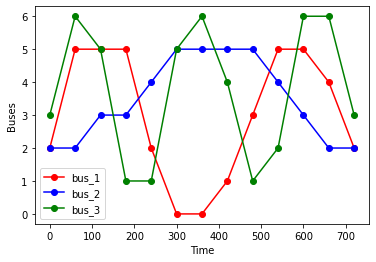

In [16]:
# route demand functions
array_t = np.array(range(0, 12*60+1, 60))

a, b, c, d = 3, 2, 0, 75
plt.plot(array_t, np.ceil(a*np.sin((array_t+c)/d) + b), 
         color='r', label='bus_1', marker='o')

a, b, c, d = 2, 3, -180, 120
plt.plot(array_t, np.ceil(a*np.sin((array_t+c)/d) + b), 
         color='b', label='bus_2', marker='o')

a, b, c, d = 3, 3, 0, 45
plt.plot(array_t, np.ceil(a*np.sin((array_t+c)/d) + b), 
         color='g', label='bus_3', marker='o')

plt.xlabel('Time')
plt.ylabel('Buses')
plt.legend()
plt.show()